In [1]:
import torch
from config_loader import load_config, get_model_name
from datasets import load_dataset
from plotting import plot_conditioned_examples

config = load_config("VQVAE_128_16")
# Load dataset
train_loader, val_loader, test_loader, image_shape = load_dataset(config["data_params"])

model_name = get_model_name(config)
print(image_shape)

torch.Size([1, 28, 28])


In [2]:
from lightning_extensions import ExtendedTrainer
from modules import VAEModule

model = VAEModule(config['model_params'], image_shape=image_shape, model_name=config['model_name'])

trainer = ExtendedTrainer(project_name="MTVAEs", **config['trainer_params'], model_name=model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/pyt ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: lightning_logs/VQVAE(128_16_[32, 64]_0)?dataset=MNIST&batch_size=128&count_sampling=EXACT&pixel_sampling=EXA

/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:630: Checkpoint directory /Home/siv34/edzak2974/projects/MastersThesis/src/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name  | Type  | Params
--------------------------------
0 | model | VQVAE | 98.9 K
--------------------------------
98.9 K    Trainable params
0         Non-trainable params
98.9 K    Total params
0.396     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 469/469 [00:09<00:00, 51.79it/s, v_num=soot, train_recon_loss_0=0.00332, train_embeddding_loss=0.00829, train_commitment_loss=0.00207, train_vq_loss=0.0104, train_loss=0.0137, val_recon_loss_0=0.00359, val_embeddding_loss=0.00855, val_commitment_loss=0.00214, val_vq_loss=0.0107, val_loss=0.0143] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 469/469 [00:09<00:00, 50.00it/s, v_num=soot, train_recon_loss_0=0.00332, train_embeddding_loss=0.00829, train_commitment_loss=0.00207, train_vq_loss=0.0104, train_loss=0.0137, val_recon_loss_0=0.00359, val_embeddding_loss=0.00855, val_commitment_loss=0.00214, val_vq_loss=0.0107, val_loss=0.0143]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


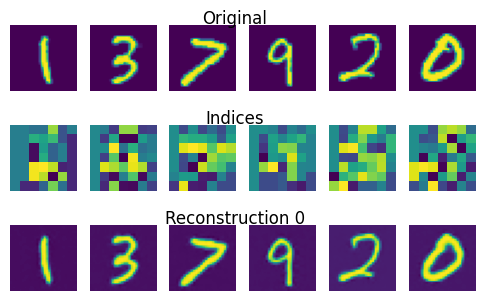

In [3]:
from modules import VAEModule
model = VAEModule.load_model_checkpoint(model_name = model_name)
model.eval()
from plotting import plot_stage_one_results
# plot some samples and their reconstruction

plot_stage_one_results(model, test_loader, save_name=model_name)

In [2]:
from config_loader import find_all_configs, load_config, get_model_name
from train import train_and_evaluate
from datasets.observations import CountSamplingMethod, PixelSamplingMethod
from copy import deepcopy

def get_sampler_pairs():
    sampler_pairs = []
    for count_sampling in CountSamplingMethod:
        for pixel_sampling in PixelSamplingMethod:
            if pixel_sampling == PixelSamplingMethod.EXACT and (count_sampling == CountSamplingMethod.VARIABLE or count_sampling == CountSamplingMethod.EXPONENTIAL or count_sampling == CountSamplingMethod.POWER_LAW):
                continue
            sampler_pairs.append((count_sampling, pixel_sampling))
    return sampler_pairs


def get_training_configs_for_dataset(dataset):
    sampler_pairs = get_sampler_pairs()
    training_configs = []
    all_configs = find_all_configs()
    for config_path in all_configs:
        config = load_config(config_path)
        model_name = config["model_name"]

        config["data_params"]["dataset"] = dataset

        is_conditioned = "SC" in model_name

        if is_conditioned:
            for count_sampling, pixel_sampling in sampler_pairs:  

                config_copy = deepcopy(config)
                config_copy["data_params"]["count_sampling"] = count_sampling.value
                config_copy["data_params"]["pixel_sampling"] = pixel_sampling.value
                config_copy["trainer_params"]["max_epochs"] = 1

                full_model_name = get_model_name(config_copy)

                print(f"Getting config: {full_model_name}")
                
                training_configs.append(config_copy)

        else:
            training_configs.append(config)

    return training_configs



for dataset in ["MNIST", "CIFAR10", "CelebA"]:
    print(f"Dataset: {dataset}")
    print("*"*20)
    res = get_training_configs_for_dataset(dataset)
    for test in res:
        full_model_name = get_model_name(test)
        print(f"Training {full_model_name}")
        #train_and_evaluate(config)

Dataset: MNIST
********************
Getting config: SCVAE1D(16)?dataset=MNIST&batch_size=128&count_sampling=EXACT&pixel_sampling=EXACT&max_epochs=1
Getting config: SCVAE1D(16)?dataset=MNIST&batch_size=128&count_sampling=EXACT&pixel_sampling=UNIFORM&max_epochs=1
Getting config: SCVAE1D(16)?dataset=MNIST&batch_size=128&count_sampling=EXACT&pixel_sampling=GAUSSIAN&max_epochs=1
Getting config: SCVAE1D(16)?dataset=MNIST&batch_size=128&count_sampling=VARIABLE&pixel_sampling=UNIFORM&max_epochs=1
Getting config: SCVAE1D(16)?dataset=MNIST&batch_size=128&count_sampling=VARIABLE&pixel_sampling=GAUSSIAN&max_epochs=1
Getting config: SCVAE1D(16)?dataset=MNIST&batch_size=128&count_sampling=EXPONENTIAL&pixel_sampling=UNIFORM&max_epochs=1
Getting config: SCVAE1D(16)?dataset=MNIST&batch_size=128&count_sampling=EXPONENTIAL&pixel_sampling=GAUSSIAN&max_epochs=1
Getting config: SCVAE1D(16)?dataset=MNIST&batch_size=128&count_sampling=POWER_LAW&pixel_sampling=UNIFORM&max_epochs=1
Getting config: SCVAE1D(16)?d